In [58]:
# IMPORTING LIBRARIES AND DEPENDENCIES:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [59]:
!pwd

/home/manel/ML_zoomcamp/03 Classification


In [60]:
# IMPORTING DATASET:
PATH = "../data/housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value","ocean_proximity"]
data = pd.read_csv(PATH, usecols=select_cols)


# Data preparation


In [61]:
data = data.fillna(0)

In [62]:
data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [63]:
data["rooms_per_household"] = data["total_rooms"].values/data["households"].values

In [64]:
data["bedrooms_per_room"] = data["total_bedrooms"].values/data["total_rooms"].values

In [65]:
data["population_per_household"] = data["population"].values/data["households"].values

In [66]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household'],
      dtype='object')

In [67]:
data["population_per_household"] 

0        2.555556
1        2.109842
2        2.802260
3        2.547945
4        2.181467
           ...   
20635    2.560606
20636    3.122807
20637    2.325635
20638    2.123209
20639    2.616981
Name: population_per_household, Length: 20640, dtype: float64

#  Question 1 What is the most frequent observation (mode) for the column ocean_proximity?

In [68]:
data.ocean_proximity.mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

<AxesSubplot:>

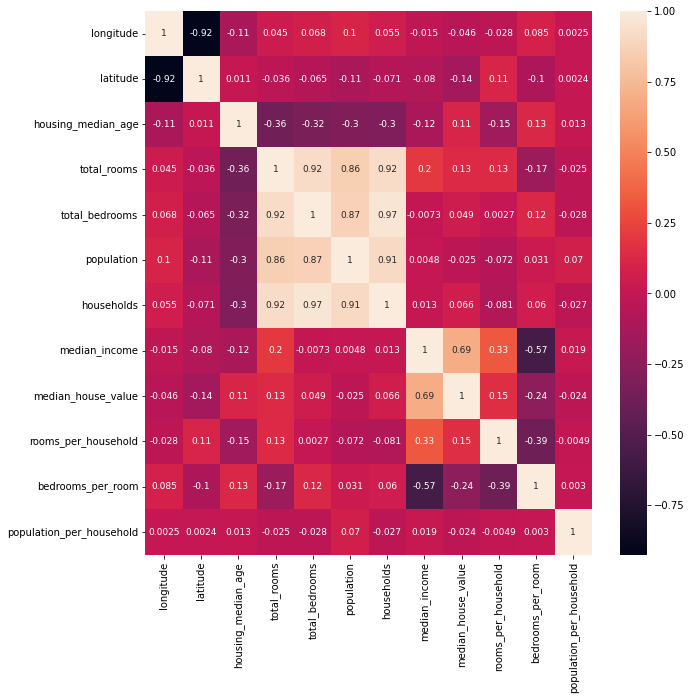

In [69]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(),annot=True, annot_kws = {"size":9})

#### total_bedrooms and households are the two features that have the biggest correlation in this dataset

## Make median_house_value binary

* We need to turn the median_house_value variable from numeric into binary.
* Let's create a variable above_average which is 1 if the median_house_value is above its mean value and 0 otherwise.

In [70]:
data.median_house_value.value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

In [71]:
data['above_average'] = data['median_house_value'].apply(lambda x: 1 if x > data['median_house_value'].mean() else 0)


In [72]:
from sklearn.model_selection import train_test_split
# Split your data in train/val/test sets, with 60%/20%/20% distribution.
df_full_train, df_test = train_test_split(data, test_size=0.20, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

# Reser all Index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [73]:
#df_train.columns

## Question 3
* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
Round it to 2 decimal digits using round(score, 2)


In [74]:
#Mutual information
from sklearn.metrics import mutual_info_score

In [75]:
categorcal_col = list(df_train.select_dtypes(object))
categorcal_col


['ocean_proximity']

In [76]:
mutual_info = mutual_info_score(df_train.above_average, df_train.ocean_proximity).round(2)
mutual_info

0.1

## Question 4
Now let's train a logistic regression
* Fit the model on the training dataset.
* To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
* model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [77]:
from sklearn.feature_extraction import DictVectorizer
# Select target value (median_house_value)
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values


df_train = df_train.drop(['median_house_value', 'above_average'], axis=1)
df_val= df_val.drop(['median_house_value', 'above_average'], axis=1)
df_test = df_test.drop(['median_house_value', 'above_average'], axis=1)

In [78]:
# One-hot encoding

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [80]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [81]:
accuracy = model.score(X_val, y_val)


In [82]:
accuracy

0.8362403100775194

## Question 5
* Let's find the least useful feature using the feature elimination technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.


In [83]:
model_coeffs = dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))
model_coeffs


{'bedrooms_per_room': 0.181,
 'households': 0.004,
 'housing_median_age': 0.036,
 'latitude': 0.116,
 'longitude': 0.087,
 'median_income': 1.212,
 'ocean_proximity=<1H OCEAN': 0.473,
 'ocean_proximity=INLAND': -1.715,
 'ocean_proximity=ISLAND': 0.019,
 'ocean_proximity=NEAR BAY': 0.292,
 'ocean_proximity=NEAR OCEAN': 0.847,
 'population': -0.002,
 'population_per_household': 0.01,
 'rooms_per_household': -0.014,
 'total_bedrooms': 0.002,
 'total_rooms': -0.0}

The least useful features (those with coefficients closer to zero) are:

* total_rooms
* total_bedrooms
* population
* households

In [85]:
least_useful = ['total_rooms',
                'total_bedrooms',
                'population',
                'households']

X_train_least = df_train[least_useful]
X_val_least = df_val[least_useful]

model_least = LogisticRegression(solver="liblinear",
                                 C=1.0,
                                 max_iter=1000,
                                 random_state=42)

model_least.fit(X_train_least, y_train)

preds = model_least.predict(X_val_least)

score_least = accuracy_score(y_val, preds)

print("Accuracy with least important features:", np.round(score_least, 3))

Accuracy with least important features: 0.71


In [88]:
full_train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=42)

# Creates features dataframes
X_train = train_df.drop(['above_average', 'median_house_value'], axis=1)
X_val = val_df.drop(['above_average', 'median_house_value'], axis=1)
X_test = test_df.drop(['above_average', 'median_house_value'], axis=1)

# Creates label arrays, with log transformation
y_train = np.log1p(train_df['median_house_value'])
y_val = np.log1p(val_df['median_house_value'])
y_test = np.log1p(test_df['median_house_value'])

# One-hot encoding

dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')

dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [90]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alphas = [0, 0.01, 0.1, 1, 10]

for a in alphas:
    model_ridge = Ridge(alpha=a, solver="sag", random_state=42)

    model_ridge.fit(X_train, y_train)

    preds_ridge = model_ridge.predict(X_val)

    score_ridge = mean_squared_error(y_val, preds_ridge, squared=False)

    print("Alpha = {}: {}".format(a, np.round(score_ridge, 3)))


Alpha = 0: 0.524
Alpha = 0.01: 0.524
Alpha = 0.1: 0.524
Alpha = 1: 0.524
Alpha = 10: 0.524
